# Example case of making RMS maps. #

If you only want to get an RMS map with _M2_ProposalTools_ , here is an example.

In [1]:
import M2_ProposalTools.MakeRMSmap as MRM
import numpy as np
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from importlib import reload

### Let's jump into what you need to get an RMS map:
---
I want the user to define parameters for a map.
Notably, the astrometry: 
(1) RA, Dec of the centroid of the map (both in degrees)
(2) Number of x and y pixels
(3) And the pixel size (in arcseconds)

The user will also need to decide on the pointings, sizes, and times of scans.
Scans are assumed to be a Lissajous daisy, LJD
Scans are assumed to be exactly on the pointings (in RA,Dec) provided unless
The size is given as a negative. If the scan is given as a negative, this script
assumes that you want offset pointings (i.e. the 4-offset pattern often adopted).
The default offset value is 1.5 (arcminutes). You can choose an alternate value if you wish.


In [2]:
Center  = [280.0, 45.0]                     # Arbitrary RA and Dec
pixsize = 2.0                               # arcseconds
xsize   = 12.0                              # arcminutes; this is a bit larger than typical
ysize   = 12.0                              # arcminutes
nx      = int(np.round(xsize*60/pixsize))   # Number of pixels (must be an integer!)
ny      = int(np.round(ysize*60/pixsize))   # Number of pixels (must be an integer!)
############################################################################################
Ptgs    = [Center]                          # Pointings should be a list of (RA,Dec) array-like values.
sizes   = [-3.5]                            # Let's try offset scans! Here, 3.5' scans, offset
times   = [10.0]                            # 10 hours
offsets = [1.5]                               # 1.5 arcminute offset (the default, but we may change it)
############################################################################################
### Some additional parameters useful for plotting
Theta500 = 3.5                             # Radius of interest, in arcminutes. If > 0, a circle will be plotted of this radius.
#500 comes from the relevance/interest for galaxy clusters


We'll take the RA,Dec value to be the *center* of the map.
If you want to offset this, you can either compute what the center (in pixels) should be
and pass them in as cx and cy. Or ...just recompute the center RA and Dec.

In [3]:
TemplateHDU = MRM.make_template_hdul(nx,ny,Center,pixsize)

In [4]:
RMSmap,nscans = MRM.make_rms_map(TemplateHDU,Ptgs,sizes,times,offsets=offsets)

In [5]:
prntinfo = True
############## Some inputs are useful if your template HDU has an actual image you want to portray 
############## with respect to your RMS map. (Do features align with desired map depth?)
ggm      = False   # Perform Gaussian Gradient Magnitude on the image of the Template HDU
ncnts    = 0       # Number of contours. 1-3 is good for highlighting features. Contours are automatically created in logarithmic
                   # spacing between the minimum (acceptable, see below) and maximum ggm values.
ggmCut   = 0.01    # This multiplied by the *maximum* of the GGM map is a threshold. So gradients < 1% are ignored/omitted.
ggmIsImg = False   # If you want to display the ggm image instead of the RMS map, you can set this to True
                   # This is primarily useful to get a handle on the values of the GGM image.(So that you may decide on values above)
###################################################################################################
vmin     = 20.0    # uK. Minimum RMS depth expected
vmax     = 200.0   # uK. Maximum RMS to be colored. 
###################################################################################################
tsource  = np.sum(times)        # Total hours on source.
R500     = Theta500*60/pixsize  # Number of pixels
R5c      = "k"                  # Black color for the circle drawn at R500 pixels
zoom     = 1.0                  # Often the map is bigger than needed; you may want to zoom in by some amount.
noaxes   = True                 # Label the axes? Often not necessary.
myfs     = 20                   # fontsize
###################################################################################################
outpng   = "Example_rmsmap_OffsetPintings_3p5each_wR500.png"

### Here we can make a plot of the RMS map! 

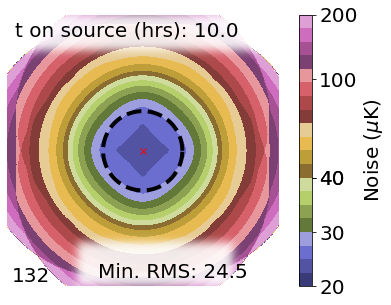

In [6]:
MRM.plot_rms_general(TemplateHDU,outpng,nscans=nscans,prntinfo=prntinfo,cra=Center[0],cdec=Center[1],
                    ggm=ggm,ncnts=ncnts,vmin=vmin,vmax=vmax,ggmCut=ggmCut,ggmIsImg=ggmIsImg,rmsmap=RMSmap,
                    tsource=tsource,R500=R500,r5col=R5c,zoom=zoom,noaxes=noaxes,myfs=myfs)

Perhaps we want to do a bit more yet. For instance, we can check how the profile of the RMS with the offset pointings comparse to that of the single pointings (which had been tabulated on <https://greenbankobservatory.org/science/gbt-observers/mustang-2/>)

First, let's calculate the RMS profiles for both cases:

In [7]:
RMSrads,RMSprof = MRM.calc_RMS_profile(TemplateHDU,RMSmap,Center)
MapSpdProf      = RMSprof * np.sqrt(np.sum(times)) 
LJD_MapSpeed    = MRM.get_rmsprof_from_s(RMSrads,-sizes[0])

Now, let's also calculate the RMS within a circular aperture. Specifically, let's do three circular apertures; that of 2, 3, and 4 arcminutes

In [8]:
Rmaxes          = [2,3,4]                        # Rmaxes of 2', 3', and 4'
AvgedMapSpds    = MRM.calculate_RMS_within(RMSrads,MapSpdProf,Rmaxes=Rmaxes)  
LJD_AvgMpSpds   = MRM.calculate_RMS_within(RMSrads,LJD_MapSpeed,Rmaxes=Rmaxes)

And let's plot this because it's prettier than just looking at numbers

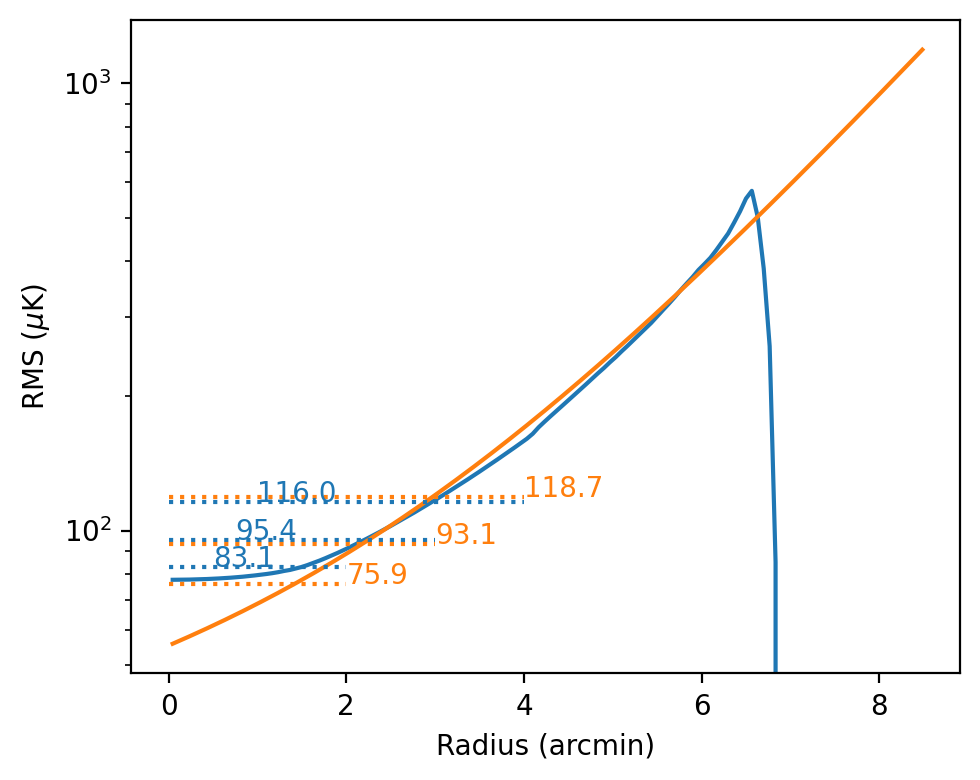

In [9]:
RMSfig = plt.figure(1,figsize=(5,4),dpi=200)
RMSfig.clf()
RMSax  = RMSfig.add_subplot(111)
RMSax.plot(RMSrads,MapSpdProf,label="3.5; Offset by 1.5")
RMSax.plot(RMSrads,LJD_MapSpeed,label="3.5; single ptg")
for Rmax,AMS,LMS in zip(Rmaxes,AvgedMapSpds,LJD_AvgMpSpds):
    RMSax.plot([0,Rmax],[AMS,AMS],ls=":",color="C0")
    RMSax.text(Rmax/4,AMS,"{:.1f}".format(AMS),color="C0")
    RMSax.plot([0,Rmax],[LMS,LMS],ls=":",color="C1")
    RMSax.text(Rmax,LMS,"{:.1f}".format(LMS),color="C1")
RMSax.set_xlabel("Radius (arcmin)")
RMSax.set_ylabel(r"RMS ($\mu$K)")
RMSax.set_yscale("log")
RMSfig.tight_layout()
RMSfig.savefig("Offset_vs_Single_Pointing_MappingSpeeds_v2.png")

First, a disclaimer: the RMS profile for a single pointing is probably overestimating the slope in the center (it should be flatter). Even so, it does monatonically decrease. However, the profile of the offset pointings (blue) is substantially flatter. The increase in noise is relatively minor, at least with the default offset of 1.5 arcminutes.

### Conclusion: offset pointings do not dramatically reduce the sensitivity in the central 2 arcminutes.